# Data Collection and Exploratory Data Analysis

The following code was run at the start of the project to collect a large corpus of documents to establish the initial data set. This code is not meant to be run again - the data is saved as a CSV file in this repository to be loaded again if necessary. Data was cleaned to remove articles that did not have sufficient quality (exact steps are in the comments in the code block itself). Cleaned data was inserted into the SQL database

```
# Import relevant libraries
import pandas as pd
import requests
import time
import pyodbc
from langdetect import detect

papers = {'title':[],
          'abstract':[],
          'authors':[],
          'journal':[],
          'link':[],
          'date':[],
          'type':[]}
          
start = True
x = 0

# Collect papers from Springer API starting from August 1. Store data in dictionary form which is then converted into a dataframe
while start:
    data = requests.get("http://api.springer.com/metadata/json?api_key=4a6226d4feb9e43bf17f2a83b4cce338&q=type:Journal onlinedatefrom:2020-08-01 onlinedateto:2020-09-01&s=" + str(x) + "&p=50")
    ream = data.json()['records']
    papers['title'] += [str(z.get('title')) for z in ream]
    papers['abstract'] += [str(z.get('abstract')) for z in ream]
    papers['link'] += [str(z.get('url')[0].get('value')) for z in ream]
    papers['date'] += [str(z.get('publicationDate')) for z in ream]
    papers['type'] += [str(z.get('contentType')) for z in ream]
    papers['journal'] += [str(z.get('publicationName')) for z in ream]
    print(papers['date'][-1])
    for paper in ream:
        authors = ''
        for author in [y.get('creator') for y in paper.get('creators')]:
            authors += author + ' | '
        authors = authors[:-3]
        papers['authors'].append(authors)

    if len(ream) < 50:
        start = False
    else:
        time.sleep(3)
        x += 50
        
df = pd.DataFrame.from_dict(papers)

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'error'

# Data cleaning
# Remove non-English entries, papers with empty/symbol filled titles and abstracts. Remove redacted/resubmitted/corrected papers (short abstract lengths). Assign unique ids to each paper

df = df.drop_duplicates(subset='title')
df = df[['{' not in df['title'][x] and '???' not in df['abstract'][x] for x in df.index]]
df = df[[detect_lang(df['title'][x]) == 'en' and detect_lang(df['abstract'][x]) == 'en' and df['date'][x][:4] == '2020' for x in df.index]]
df = df[[len(df['abstract'][x]) > 150 for x in df.index]]
df.sort_values(by=['date', 'title'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['id'] = np.arange(1, len(df)+1)

# Save to CSV file for easy access in the future if necessary. Save data to SQL database for use by the application
df.to_csv('../data/papers.csv',index=False)

cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=ga-cc12-s5.database.windows.net;DATABASE=capstone;UID=[REDACTED];PWD=[REDACTED]')
cursor = cnxn.cursor()
for index, row in df.iterrows():
    cursor.execute("INSERT INTO papers (title, abstract, authors, journal, link, date, id) values (?,?,?,?,?,?,?)", row['title'], row['abstract'], row['authors'], row['journal'], row['link'], row['date'], row['id'])
cnxn.commit()
cursor.close()
```

# EDA

While I was less interested in exploring the data to gain insight, it is still useful to know some basic information about the papers being pulled from the API. Using this information will allow for a better sense of fluctuations of data coming in the future.

In [1]:
# Import relevant libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Load data set from the CSV file

clean_df = pd.read_csv('../data/papers.csv')
clean_df.head()

,title,abstract,authors,journal,link,date,id
0,Applicability of Minifloats for Efficient Calc...,The possibility of the inference of neural net...,"Kondrat’ev, A. Yu. | Goncharenko, A. I.","Optoelectronics, Instrumentation and Data Proc...",http://dx.doi.org/10.3103/S8756699020010100,2020-01-01,1
1,Application of Capacitive Microstructures as A...,This paper first considers an approach based o...,"Rybak, A. A. | Nikolaev, N. A. | Kuznetsov, S....","Optoelectronics, Instrumentation and Data Proc...",http://dx.doi.org/10.3103/S8756699020010136,2020-01-01,2
2,Classification of Seismoacoustic Emission Sour...,A new method is proposed for automatic classif...,"Timofeev, A. V. | Groznov, D. I.","Optoelectronics, Instrumentation and Data Proc...",http://dx.doi.org/10.3103/S8756699020010070,2020-01-01,3
3,Construction of Constitutive Equations for Ort...,Constitutive steady-state creep equations are ...,"Banshchikova, I. A.",Journal of Applied Mechanics and Technical Phy...,http://dx.doi.org/10.1134/S0021894420010101,2020-01-01,4
4,Delamination of a Coating from an Elastic Subs...,Known models were used to investigate the dela...,"Vatul’yan, A. O. | Morozov, K. L.",Journal of Applied Mechanics and Technical Phy...,http://dx.doi.org/10.1134/S0021894420010125,2020-01-01,5


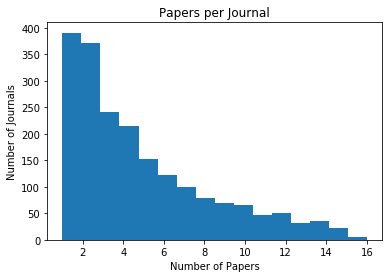

In [3]:
# Histogram of how represented each journal is in the data set. Most journals only had one or two articles, resulting in a very left-skewed distribution

dist = [len(clean_df[clean_df['journal'] == x]) for x in set(clean_df['journal'])]
dist.sort()
plt.hist(dist[:2000], bins=16)
plt.title('Papers per Journal')
plt.ylabel('Number of Journals')
plt.xlabel('Number of Papers')
plt.show()

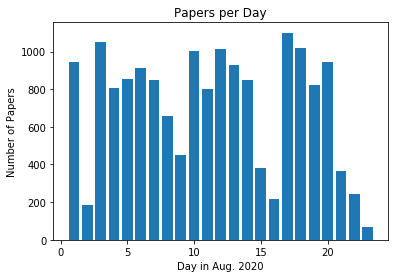

In [5]:
# Distribution of papers published over time. There is a clear seasonality to the data - publications are fewer during the weekend as would be expected. On average, a given week day has around 800 papers published

dates = []
paper_no = []
for x in range(1,24):
    if x < 10:
        date = '2020-08-0' + str(x)
    else:
        date = '2020-08-' + str(x)
    paper_no.append(len(clean_df[clean_df['date']==date]))
    dates.append(date)
plt.bar(np.arange(1,len(paper_no)+1), paper_no)
plt.title('Papers per Day')
plt.ylabel('Number of Papers')
plt.xlabel('Day in Aug. 2020')
plt.show()